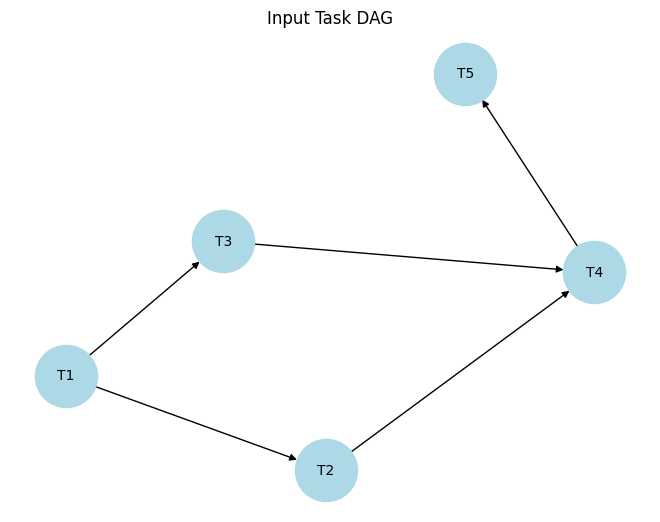

Best Makespan: 46.67, Energy: 160.00


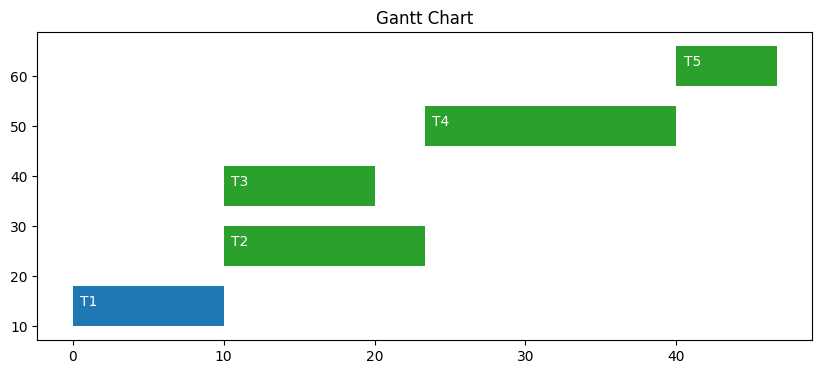

In [4]:
# === CGO-based Bi-Objective Workflow Scheduler ===
# - Uses DAG input
# - Computes EST and upward rank
# - Uses CGO + random alpha/beta for priority
# - Schedules on heterogeneous VMs
# - Enforces topological repair for valid scheduling

import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Task and VM ===
class Task:
    def __init__(self, id, exec_time, dependencies=[]):
        self.id = id
        self.exec_time = exec_time
        self.dependencies = dependencies
        self.est = 0
        self.rank = 0

class VM:
    def __init__(self, id, speed, energy_factor):
        self.id = id
        self.speed = speed
        self.energy_factor = energy_factor

# === Build DAG and compute EST ===
def compute_est(tasks):
    task_dict = {t.id: t for t in tasks}
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t.id)
        for d in t.dependencies:
            G.add_edge(d, t.id)

    topo = list(nx.topological_sort(G))
    for tid in topo:
        t = task_dict[tid]
        t.est = max([task_dict[d].est + task_dict[d].exec_time for d in t.dependencies] or [0])

# === Upward rank (used in HEFT) ===
def compute_ranku(tasks):
    task_dict = {t.id: t for t in tasks}
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t.id)
        for d in t.dependencies:
            G.add_edge(d, t.id)

    reverse_topo = list(reversed(list(nx.topological_sort(G))))
    for tid in reverse_topo:
        t = task_dict[tid]
        succ = list(G.successors(tid))
        if not succ:
            t.rank = t.exec_time
        else:
            t.rank = t.exec_time + max(task_dict[s].rank for s in succ)

# === Priority = alpha * EST + beta * rank ===
def compute_priority(tasks):
    alpha = random.random()
    beta = 1 - alpha
    priorities = {}
    for t in tasks:
        priorities[t.id] = alpha * t.est + beta * t.rank
    return sorted(priorities, key=priorities.get)

# === Enforce Topological Order ===
def repair_topological_order(priority_list, tasks):
    task_dict = {t.id: t for t in tasks}
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t.id)
        for d in t.dependencies:
            G.add_edge(d, t.id)

    visited = set()
    fixed_order = []

    def visit(tid):
        if tid in visited:
            return
        for d in task_dict[tid].dependencies:
            visit(d)
        visited.add(tid)
        fixed_order.append(tid)

    for tid in priority_list:
        visit(tid)

    return fixed_order

# === Scheduler ===
def schedule_tasks(priority_order, tasks, vms):
    task_dict = {t.id: t for t in tasks}
    schedule = {}
    for tid in priority_order:
        task = task_dict[tid]
        ready_time = max([schedule[d]['end_time'] for d in task.dependencies] or [0])
        vm = random.choice(vms)
        exec_time = task.exec_time / vm.speed
        end_time = ready_time + exec_time
        energy = exec_time * vm.energy_factor
        schedule[tid] = {
            'vm': vm.id,
            'start_time': ready_time,
            'end_time': end_time,
            'energy': energy
        }
    return schedule

# === CGO update ===
def logistic_map(x):
    return 3.99 * x * (1 - x)

def apply_cgo(current, elites, iterations=3):
    x = random.random()
    new_priority = current[:]
    for _ in range(iterations):
        x = logistic_map(x)
        elite = random.choice(elites)
        for i in range(len(new_priority)):
            if random.random() < x:
                new_priority[i] = elite[i]
    return new_priority

# === Evaluate ===
def evaluate(schedule):
    if not schedule:
        return float('inf'), float('inf')
    makespan = max(s['end_time'] for s in schedule.values())
    energy = sum(s['energy'] for s in schedule.values())
    return makespan, energy

# === Visualizations ===
def draw_dag(tasks):
    G = nx.DiGraph()
    for t in tasks:
        G.add_node(t.id)
        for d in t.dependencies:
            G.add_edge(d, t.id)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)
    plt.title("Input Task DAG")
    plt.show()

def plot_gantt(schedule):
    tasks = list(schedule.items())
    tasks.sort(key=lambda x: x[1]['start_time'])
    fig, ax = plt.subplots(figsize=(10, 4))
    y = 10
    for tid, info in tasks:
        color = 'tab:blue' if info['vm'] == 'VM1' else 'tab:green'
        ax.broken_barh([(info['start_time'], info['end_time'] - info['start_time'])], (y, 8), facecolors=color)
        ax.text(info['start_time'] + 0.5, y+4, tid, color='white')
        y += 12
    ax.set_title("Gantt Chart")
    plt.show()

# === Main ===
if __name__ == '__main__':
    tasks = [
        Task("T1", 10),
        Task("T2", 20, ["T1"]),
        Task("T3", 15, ["T1"]),
        Task("T4", 25, ["T2", "T3"]),
        Task("T5", 10, ["T4"])
    ]

    vms = [
        VM("VM1", 1.0, 2.0),
        VM("VM2", 1.5, 3.0)
    ]

    draw_dag(tasks)
    compute_est(tasks)
    compute_ranku(tasks)
    pop = []

    # Initial population
    for _ in range(10):
        prio = compute_priority(tasks)
        prio = repair_topological_order(prio, tasks)
        sched = schedule_tasks(prio, tasks, vms)
        m, e = evaluate(sched)
        pop.append({'priority': prio, 'sched': sched, 'makespan': m, 'energy': e})

    # CGO optimization
    for gen in range(20):
        pop.sort(key=lambda x: (x['makespan'], x['energy']))
        elites = [p['priority'] for p in pop[:3]]
        new_pop = []
        for p in pop:
            new_prio = apply_cgo(p['priority'], elites)
            new_prio = repair_topological_order(new_prio, tasks)
            sched = schedule_tasks(new_prio, tasks, vms)
            m, e = evaluate(sched)
            new_pop.append({'priority': new_prio, 'sched': sched, 'makespan': m, 'energy': e})
        pop = new_pop

    best = min(pop, key=lambda x: (x['makespan'], x['energy']))
    print(f"Best Makespan: {best['makespan']:.2f}, Energy: {best['energy']:.2f}")
    plot_gantt(best['sched'])